## 1. Importing Libraries

In [194]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import(
      BaseEstimator,
      TransformerMixin
)
from sklearn.pipeline import(
      Pipeline,
      FeatureUnion
)
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import(
      OneHotEncoder,
      OrdinalEncoder,
      StandardScaler,
      MinMaxScaler,
      PowerTransformer,
      FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.encoding import(
      RareLabelEncoder,
      MeanEncoder,
      CountFrequencyEncoder
)
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance

from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',None)
sklearn.set_config(transform_output = "pandas")

## 2. Reading the Data

In [10]:
PROJECT_DIR = Path(r'F:\Rishabh\Flight-Price-Prediction')
DATA_DIR = "data/train"

In [12]:
def read_data(name):
    file_name = f"{name}.csv"
    file_path = PROJECT_DIR/DATA_DIR/file_name

    return pd.read_csv(file_path)

In [14]:
data = read_data("train")

In [16]:
data

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-03-03,Delhi,Cochin,02:15:00,04:25:00,1570,1.0,No Info,17024
1,Vistara,2019-03-24,Kolkata,Bangalore,07:10:00,18:45:00,695,1.0,No Info,16932
2,Spicejet,2019-04-09,Bangalore,Delhi,09:30:00,12:20:00,170,0.0,No Info,4423
3,Indigo,2019-04-27,Bangalore,Delhi,21:15:00,00:15:00,180,0.0,No Info,3943
4,Air India,2019-06-12,Delhi,Cochin,09:45:00,09:25:00,1420,1.0,No Info,7480
...,...,...,...,...,...,...,...,...,...,...
6831,Indigo,2019-06-03,Bangalore,Delhi,04:00:00,06:50:00,170,0.0,No Info,3943
6832,Indigo,2019-06-24,Delhi,Cochin,05:05:00,16:10:00,665,1.0,No Info,6442
6833,Air India,2019-05-09,Bangalore,Delhi,10:00:00,12:45:00,165,0.0,No Info,5228
6834,Jet Airways,2019-05-27,Delhi,Cochin,07:05:00,12:35:00,330,1.0,In-flight meal not included,12898


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6836 entries, 0 to 6835
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          6836 non-null   object 
 1   date_of_journey  6836 non-null   object 
 2   source           6836 non-null   object 
 3   destination      6836 non-null   object 
 4   dep_time         6836 non-null   object 
 5   arrival_time     6836 non-null   object 
 6   duration         6836 non-null   int64  
 7   total_stops      6835 non-null   float64
 8   additional_info  6836 non-null   object 
 9   price            6836 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 534.2+ KB


In [18]:
X_train = data.drop(columns = "price")
y_train = data.price.copy()

## 3. Transformation Operations

In [21]:
X_train.columns.to_list()

['airline',
 'date_of_journey',
 'source',
 'destination',
 'dep_time',
 'arrival_time',
 'duration',
 'total_stops',
 'additional_info']

### 3.1 `airline`

In [22]:
X_train.airline

0       Jet Airways
1           Vistara
2          Spicejet
3            Indigo
4         Air India
           ...     
6831         Indigo
6832         Indigo
6833      Air India
6834    Jet Airways
6835          Goair
Name: airline, Length: 6836, dtype: object

In [46]:
air_transformer = Pipeline(
    steps = [
        ("imputer",SimpleImputer(strategy = "most_frequent")),
        ("grouper",RareLabelEncoder(tol = 0.1, replace_with = "Other",n_categories = 2)),
        ("encoder",OneHotEncoder(sparse_output = False, handle_unknown = "ignore"))
    ]
)

air_transformer.fit_transform(X_train.loc[:,["airline"]])

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
6831,0.0,1.0,0.0,0.0,0.0
6832,0.0,1.0,0.0,0.0,0.0
6833,1.0,0.0,0.0,0.0,0.0
6834,0.0,0.0,1.0,0.0,0.0


### 3.2 `date_of_journey`

In [41]:
X_train.date_of_journey

0       2019-03-03
1       2019-03-24
2       2019-04-09
3       2019-04-27
4       2019-06-12
           ...    
6831    2019-06-03
6832    2019-06-24
6833    2019-05-09
6834    2019-05-27
6835    2019-03-03
Name: date_of_journey, Length: 6836, dtype: object

In [51]:
features_to_extract = ["month","week","day_of_week","day_of_year"]

doj_transformer = Pipeline(steps = [
    ("dt",DatetimeFeatures(features_to_extract = features_to_extract, yearfirst = True, format = "mixed")),
    ("scaler",MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:,['date_of_journey']])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.000000,0.000000,1.000000,0.016949
1,0.000000,0.176471,1.000000,0.194915
2,0.333333,0.352941,0.166667,0.330508
3,0.333333,0.470588,0.833333,0.483051
4,1.000000,0.882353,0.333333,0.872881
...,...,...,...,...
6831,1.000000,0.823529,0.000000,0.796610
6832,1.000000,1.000000,0.000000,0.974576
6833,0.666667,0.588235,0.500000,0.584746
6834,0.666667,0.764706,0.000000,0.737288


### 3.3 `source` and `destination`

In [53]:
X_train.source

0           Delhi
1         Kolkata
2       Bangalore
3       Bangalore
4           Delhi
          ...    
6831    Bangalore
6832        Delhi
6833    Bangalore
6834        Delhi
6835        Delhi
Name: source, Length: 6836, dtype: object

In [54]:
X_train.destination

0          Cochin
1       Bangalore
2           Delhi
3           Delhi
4          Cochin
          ...    
6831        Delhi
6832       Cochin
6833        Delhi
6834       Cochin
6835       Cochin
Name: destination, Length: 6836, dtype: object

In [55]:
location_subset = X_train.loc[:,["source","destination"]]
location_subset

,source,destination
0,Delhi,Cochin
1,Kolkata,Bangalore
2,Bangalore,Delhi
3,Bangalore,Delhi
4,Delhi,Cochin
...,...,...
6831,Bangalore,Delhi
6832,Delhi,Cochin
6833,Bangalore,Delhi
6834,Delhi,Cochin


In [69]:
location_pipe = Pipeline(steps = [
    ("grouper",RareLabelEncoder(tol = 0.1,replace_with = "Other",n_categories = 2)),
    ("encoder",MeanEncoder()),
    ("scaler",PowerTransformer())
])

location_pipe.fit_transform(location_subset,y_train)

,source,destination
0,1.048486,1.048486
1,-0.197994,-0.197994
2,-0.934208,-0.934208
3,-0.934208,-0.934208
4,1.048486,1.048486
...,...,...
6831,-0.934208,-0.934208
6832,1.048486,1.048486
6833,-0.934208,-0.934208
6834,1.048486,1.048486


In [70]:
np.union1d(
    data.source.unique(),
    data.destination.unique()
)

array(['Bangalore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai'], dtype=object)

In [75]:
def is_north(X):
    columns = X.columns.to_list()
    north_cities = ["Delhi","Kolkata","Mumbai","New Delhi"]
    return (
        X
        .assign(
            **{
                f"{col}_isnorth": X.loc[:,col].isin(north_cities).astype('int')
                for col in columns
            }
        )
        .drop(columns = columns)
    )

FunctionTransformer(func = is_north).fit_transform(location_subset)

,source_isnorth,destination_isnorth
0,1,0
1,1,0
2,0,1
3,0,1
4,1,0
...,...,...
6831,0,1
6832,1,0
6833,0,1
6834,1,0


In [78]:
location_transformer = FeatureUnion(transformer_list = [
    ("pipe1",location_pipe),
    ("pipe2",FunctionTransformer(func = is_north))
])

location_transformer.fit_transform(location_subset,y_train)

,source,destination,source_isnorth,destination_isnorth
0,1.048486,1.048486,1,0
1,-0.197994,-0.197994,1,0
2,-0.934208,-0.934208,0,1
3,-0.934208,-0.934208,0,1
4,1.048486,1.048486,1,0
...,...,...,...,...
6831,-0.934208,-0.934208,0,1
6832,1.048486,1.048486,1,0
6833,-0.934208,-0.934208,0,1
6834,1.048486,1.048486,1,0


### 3.4 `dep_time` and `arrival_time`

In [80]:
X_train.dep_time

0       02:15:00
1       07:10:00
2       09:30:00
3       21:15:00
4       09:45:00
          ...   
6831    04:00:00
6832    05:05:00
6833    10:00:00
6834    07:05:00
6835    14:10:00
Name: dep_time, Length: 6836, dtype: object

In [81]:
X_train.arrival_time

0       04:25:00
1       18:45:00
2       12:20:00
3       00:15:00
4       09:25:00
          ...   
6831    06:50:00
6832    16:10:00
6833    12:45:00
6834    12:35:00
6835    19:20:00
Name: arrival_time, Length: 6836, dtype: object

In [99]:
def part_of_the_day(X,morning = 4,afternoon = 12, evening =16,night = 20):
    columns = X.columns.to_list()
    X_temp = X.assign(**{
        col: pd.to_datetime(X.loc[:,col]).dt.hour
        for col in columns
    })

    return(
        X_temp.assign(**{
                f"{col}_part_of_day" : np.select(
                    [X_temp.loc[:,col].between(morning,afternoon,inclusive = "left"),
                     X_temp.loc[:,col].between(afternoon,evening,inclusive = "left"),
                     X_temp.loc[:,col].between(evening,night,inclusive = "left")],
                    ["morning","afternoon","evening"],
                    default = "night"
            )

                for col in columns
        })
        .drop(columns = columns)
    )

FunctionTransformer(part_of_the_day).fit_transform(X_train.loc[:,["dep_time","arrival_time"]])

,dep_time_part_of_day,arrival_time_part_of_day
0,night,morning
1,morning,evening
2,morning,afternoon
3,night,night
4,morning,morning
...,...,...
6831,morning,morning
6832,morning,evening
6833,morning,afternoon
6834,morning,afternoon


In [84]:
time_pipe = Pipeline(steps= [
    ("dt",DatetimeFeatures(features_to_extract = ["hour","minute"])),
])

time_pipe.fit_transform(X_train.loc[:,["dep_time","arrival_time"]])

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,2,15,4,25
1,7,10,18,45
2,9,30,12,20
3,21,15,0,15
4,9,45,9,25
...,...,...,...,...
6831,4,0,6,50
6832,5,5,16,10
6833,10,0,12,45
6834,7,5,12,35


In [103]:
time_pipe2 = Pipeline(steps =[
    ("part",FunctionTransformer(part_of_the_day)),
    ("encoder",CountFrequencyEncoder()),
    ("scaler",MinMaxScaler())
])

time_pipe2.fit_transform(X_train.loc[:,["dep_time","arrival_time"]])

,dep_time_part_of_day,arrival_time_part_of_day
0,0.130625,0.944106
1,1.000000,0.681911
2,1.000000,0.000000
3,0.130625,1.000000
4,1.000000,0.944106
...,...,...
6831,1.000000,0.944106
6832,1.000000,0.681911
6833,1.000000,0.000000
6834,1.000000,0.000000


In [104]:
time_transformer = FeatureUnion(transformer_list = [
    ("part1",time_pipe),
    ("part2",time_pipe2)
])

time_transformer.fit_transform(X_train.loc[:,["dep_time","arrival_time"]])

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,2,15,4,25,0.130625,0.944106
1,7,10,18,45,1.000000,0.681911
2,9,30,12,20,1.000000,0.000000
3,21,15,0,15,0.130625,1.000000
4,9,45,9,25,1.000000,0.944106
...,...,...,...,...,...,...
6831,4,0,6,50,1.000000,0.944106
6832,5,5,16,10,1.000000,0.681911
6833,10,0,12,45,1.000000,0.000000
6834,7,5,12,35,1.000000,0.000000


### 3.5 `duration`

In [106]:
X_train.duration

0       1570
1        695
2        170
3        180
4       1420
        ... 
6831     170
6832     665
6833     165
6834     330
6835     310
Name: duration, Length: 6836, dtype: int64

In [115]:
(
    X_train
    .duration
    .quantile([0.25,0.5,0.75])
    .values
    .reshape(-1,1)
    # .shape
)

array([[170.],
       [510.],
       [930.]])

In [139]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self,variables = None, percentiles = [0.25,0.5,0.75], gamma = 0.1):
        self.variables = variables
        self.percentiles = percentiles
        self.gamma = gamma

    def fit(self,X,y = None):
        if not self.variables:
            self.variables = X.select_dtypes(include = "number").columns.to_list()

        self.reference_values_ = {
            col: (
                X
                .loc[:,col]
                .quantile(self.percentiles)
                .values
                .reshape(-1,1)
            )
            for col in self.variables
        }

        return self

    def transform(self,X):
         objects = []
         for col in self.variables:
             columns = [f"{col}_rbf_{int(percentile*100)}" for percentile in self.percentiles]
             obj = pd.DataFrame(
                 data = rbf_kernel(X.loc[:,[col]], Y = self.reference_values_[col], gamma = self.gamma),
                 columns = columns
             )
             objects.append(obj)
         return pd.concat(objects,axis=1)

In [146]:
rbf = RBFPercentileSimilarity()
rbf.fit_transform(X_train.loc[:,["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75
0,0.000000,0.0,0.0
1,0.000000,0.0,0.0
2,1.000000,0.0,0.0
3,0.000045,0.0,0.0
4,0.000000,0.0,0.0
...,...,...,...
6831,1.000000,0.0,0.0
6832,0.000000,0.0,0.0
6833,0.082085,0.0,0.0
6834,0.000000,0.0,0.0


In [156]:
def duration_category(X,short = 180,med =400):
    return (
        X.assign(
        duration_cat = np.select(
            [X.duration.lt(short),
             X.duration.between(short,med,inclusive = "left")],
            ["short","medium"],
            default = "long"
        )
    )
    .drop(columns = "duration")
   )

FunctionTransformer(duration_category).fit_transform(X_train.loc[:,["duration"]])

,duration_cat
0,long
1,long
2,short
3,medium
4,long
...,...
6831,short
6832,long
6833,short
6834,medium


In [157]:
def is_over(X,value = 1000):
    return(
        X.assign(**{
            f"duration_over_{value}": X.duration.gt(1000).astype(int)
        })
        .drop(columns = "duration")
    )

FunctionTransformer(is_over).fit_transform(X_train.loc[:,["duration"]])

,duration_over_1000
0,1
1,0
2,0
3,0
4,1
...,...
6831,0
6832,0
6833,0
6834,0


In [165]:
duration_pipe1 = Pipeline(steps = [
    ("rbf",RBFPercentileSimilarity()),
    ("scaler",PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe1),
	("part2", duration_pipe2),
	("part3", FunctionTransformer(func=is_over)),
	("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.365126,-0.106587,-0.089572,2.0,1,1.865105
1,-0.365126,-0.106587,-0.089572,2.0,0,0.117256
2,3.107080,-0.106587,-0.089572,0.0,0,-0.931453
3,-0.362096,-0.106587,-0.089572,1.0,0,-0.911478
4,-0.365126,-0.106587,-0.089572,2.0,1,1.565474
...,...,...,...,...,...,...
6831,3.107080,-0.106587,-0.089572,0.0,0,-0.931453
6832,-0.365126,-0.106587,-0.089572,2.0,0,0.057330
6833,2.345563,-0.106587,-0.089572,0.0,0,-0.941441
6834,-0.365126,-0.106587,-0.089572,1.0,0,-0.611847


### 3.6 `total_stops`

In [180]:
X_train.total_stops

0       1.0
1       1.0
2       0.0
3       0.0
4       1.0
       ... 
6831    0.0
6832    1.0
6833    0.0
6834    1.0
6835    1.0
Name: total_stops, Length: 6836, dtype: float64

In [182]:
def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,1.0,0
1,1.0,0
2,0.0,1
3,0.0,1
4,1.0,0
...,...,...
6831,0.0,1
6832,1.0,0
6833,0.0,1
6834,1.0,0


## 3.7 `additional_info`

In [169]:
X_train.additional_info

0                           No Info
1                           No Info
2                           No Info
3                           No Info
4                           No Info
                   ...             
6831                        No Info
6832                        No Info
6833                        No Info
6834    In-flight meal not included
6835                        No Info
Name: additional_info, Length: 6836, dtype: object

In [170]:
info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
6831,0.0,1.0,0.0
6832,0.0,1.0,0.0
6833,0.0,1.0,0.0
6834,1.0,0.0,0.0


In [177]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [178]:
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])

In [179]:
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,0.0,1.0,0.0,0
...,...,...,...,...
6831,0.0,1.0,0.0,0
6832,0.0,1.0,0.0,0
6833,0.0,1.0,0.0,0
6834,1.0,0.0,0.0,1


## 4. Column Transfomer

In [184]:
column_transformer = ColumnTransformer(transformers = [
    ("air",air_transformer,["airline"]),
    ("doj",doj_transformer,["date_of_journey"]),
    ("location",location_transformer,["source","destination"]),
    ("time",time_transformer,["arrival_time","dep_time"]),
    ("dur", duration_transformer, ["duration"]),
	("stops", total_stops_transformer, ["total_stops"]),
	("info", info_transformer, ["additional_info"])
], remainder = "passthrough")

column_transformer.fit_transform(X_train,y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_isnorth,location__destination_isnorth,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_hour,time__dep_time_minute,time__arrival_time_part_of_day,time__dep_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,1.000000,0.016949,1.048486,1.048486,1,0,4,25,2,15,0.944106,0.130625,-0.365126,-0.106587,-0.089572,2.0,1,1.865105,1.0,0,0.0,1.0,0.0,0
1,0.0,0.0,0.0,0.0,1.0,0.000000,0.176471,1.000000,0.194915,-0.197994,-0.197994,1,0,18,45,7,10,0.681911,1.000000,-0.365126,-0.106587,-0.089572,2.0,0,0.117256,1.0,0,0.0,1.0,0.0,0
2,0.0,0.0,0.0,0.0,1.0,0.333333,0.352941,0.166667,0.330508,-0.934208,-0.934208,0,1,12,20,9,30,0.000000,1.000000,3.107080,-0.106587,-0.089572,0.0,0,-0.931453,0.0,1,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0.0,0.0,0.333333,0.470588,0.833333,0.483051,-0.934208,-0.934208,0,1,0,15,21,15,1.000000,0.130625,-0.362096,-0.106587,-0.089572,1.0,0,-0.911478,0.0,1,0.0,1.0,0.0,0
4,1.0,0.0,0.0,0.0,0.0,1.000000,0.882353,0.333333,0.872881,1.048486,1.048486,1,0,9,25,9,45,0.944106,1.000000,-0.365126,-0.106587,-0.089572,2.0,1,1.565474,1.0,0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6831,0.0,1.0,0.0,0.0,0.0,1.000000,0.823529,0.000000,0.796610,-0.934208,-0.934208,0,1,6,50,4,0,0.944106,1.000000,3.107080,-0.106587,-0.089572,0.0,0,-0.931453,0.0,1,0.0,1.0,0.0,0
6832,0.0,1.0,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.974576,1.048486,1.048486,1,0,16,10,5,5,0.681911,1.000000,-0.365126,-0.106587,-0.089572,2.0,0,0.057330,1.0,0,0.0,1.0,0.0,0
6833,1.0,0.0,0.0,0.0,0.0,0.666667,0.588235,0.500000,0.584746,-0.934208,-0.934208,0,1,12,45,10,0,0.000000,1.000000,2.345563,-0.106587,-0.089572,0.0,0,-0.941441,0.0,1,0.0,1.0,0.0,0
6834,0.0,0.0,1.0,0.0,0.0,0.666667,0.764706,0.000000,0.737288,1.048486,1.048486,1,0,12,35,7,5,0.000000,1.000000,-0.365126,-0.106587,-0.089572,1.0,0,-0.611847,1.0,0,1.0,0.0,0.0,1


## 5. Feature Selection

In [188]:
estimator = RandomForestRegressor()

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

## 6. Final Processor

In [189]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,time__arrival_time_hour,dur__duration_rbf_25,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,1.0,0.0,0.000000,0.016949,1.048486,1.048486,4,-0.365126,2.0,1,1.865105,1.0,0
1,0.0,0.0,1.0,0.176471,0.194915,-0.197994,-0.197994,18,-0.365126,2.0,0,0.117256,1.0,0
2,0.0,0.0,1.0,0.352941,0.330508,-0.934208,-0.934208,12,3.107080,0.0,0,-0.931453,0.0,1
3,1.0,0.0,0.0,0.470588,0.483051,-0.934208,-0.934208,0,-0.362096,1.0,0,-0.911478,0.0,1
4,0.0,0.0,0.0,0.882353,0.872881,1.048486,1.048486,9,-0.365126,2.0,1,1.565474,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6831,1.0,0.0,0.0,0.823529,0.796610,-0.934208,-0.934208,6,3.107080,0.0,0,-0.931453,0.0,1
6832,1.0,0.0,0.0,1.000000,0.974576,1.048486,1.048486,16,-0.365126,2.0,0,0.057330,1.0,0
6833,0.0,0.0,0.0,0.588235,0.584746,-0.934208,-0.934208,12,2.345563,0.0,0,-0.941441,0.0,1
6834,0.0,1.0,0.0,0.764706,0.737288,1.048486,1.048486,12,-0.365126,1.0,0,-0.611847,1.0,0


## 7. Visualisations

In [190]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': np.float64(0.0018910781902853706),
 'air__airline_Indigo': np.float64(0.1338482245396356),
 'air__airline_Jet Airways': np.float64(0.18738939550468303),
 'air__airline_Multiple Carriers': np.float64(0.01843696898590001),
 'air__airline_Other': np.float64(0.11043404735546374),
 'doj__date_of_journey_month': np.float64(0.08727779496932513),
 'doj__date_of_journey_week': np.float64(0.19338823348594072),
 'doj__date_of_journey_day_of_week': np.float64(0.003564731126648161),
 'doj__date_of_journey_day_of_year': np.float64(0.24962730553077986),
 'location__source': np.float64(0.13385374102374945),
 'location__destination': np.float64(0.1337786772181565),
 'location__source_isnorth': np.float64(0.04100969246766487),
 'location__destination_isnorth': np.float64(0.04106009015954618),
 'time__arrival_time_hour': np.float64(0.13704695244949738),
 'time__arrival_time_minute': np.float64(0.05124433958997513),
 'time__dep_time_hour': np.float64(0.02284857498909128),
 'time

In [199]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1], reverse = True))
sorted_feat_imp

{'dur__duration': np.float64(0.449307185280759),
 'stops__total_stops': np.float64(0.409695233339233),
 'dur__duration_cat': np.float64(0.39842477808691884),
 'stops__is_direct_flight': np.float64(0.3838463848411317),
 'doj__date_of_journey_day_of_year': np.float64(0.24962730553077986),
 'doj__date_of_journey_week': np.float64(0.19338823348594072),
 'air__airline_Jet Airways': np.float64(0.18738939550468303),
 'dur__duration_rbf_25': np.float64(0.16174408587867875),
 'time__arrival_time_hour': np.float64(0.13704695244949738),
 'location__source': np.float64(0.13385374102374945),
 'air__airline_Indigo': np.float64(0.1338482245396356),
 'location__destination': np.float64(0.1337786772181565),
 'dur__duration_over_1000': np.float64(0.1125654563810425),
 'air__airline_Other': np.float64(0.11043404735546374),
 'doj__date_of_journey_month': np.float64(0.08727779496932513),
 'time__arrival_time_minute': np.float64(0.05124433958997513),
 'time__dep_time_minute': np.float64(0.0440316609141664),

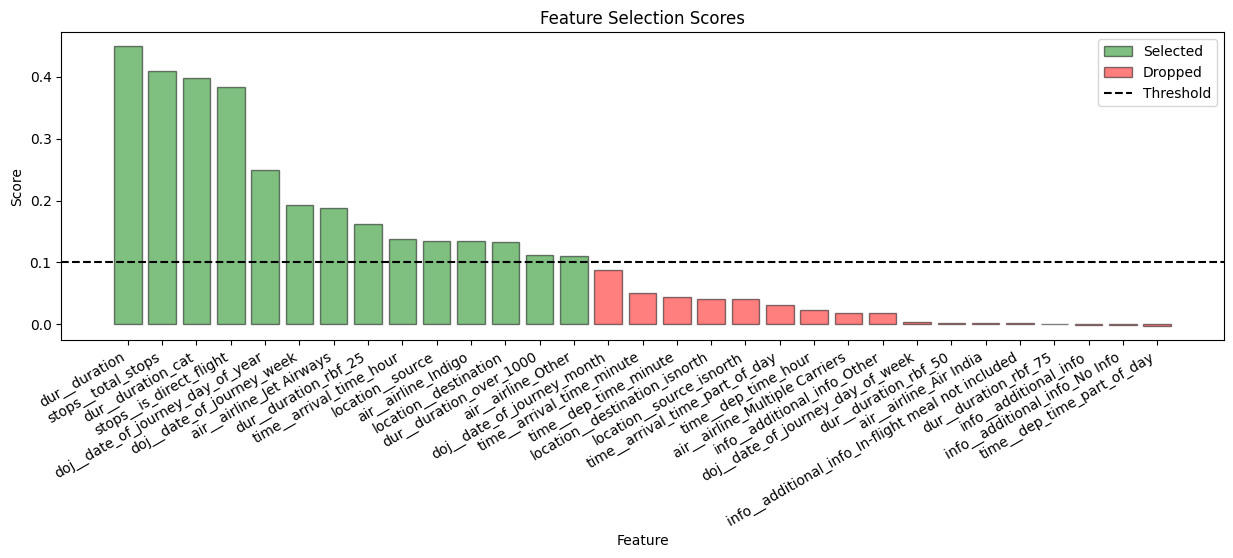

In [197]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper right",
    bbox_to_anchor = (1,1)
)

plt.show()

- The feature selection only selected 14 algorithms out of 31